In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

In [2]:
# Initializations #
num_classes = 10
channels = 1
height = 28
width = 28
latent = 100
path = '/home/cff/raghav/CGAN/results/'
onehot = np.eye(num_classes)

In [3]:
# Importing data #
def get_data():
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("/tmp/data/", one_hot=True, reshape=[])
    return mnist

In [4]:
mnist = get_data()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
x_train = mnist.train.images
y_train = mnist.train.labels
x_test = mnist.test.images
y_test = mnist.test.labels
print (x_train.shape)
print (x_train[0].shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

(55000, 28, 28, 1)
(28, 28, 1)
(55000, 10)
(10000, 28, 28, 1)
(10000, 10)


In [6]:
x_train = x_train[:5000 , : ,: ,:]
y_train = y_train[:5000, :]
shuffle_idxs = np.arange(x_train.shape[0])
np.random.shuffle(shuffle_idxs)
shuffled_x_train = x_train[shuffle_idxs]
shuffled_y_train = y_train[shuffle_idxs]

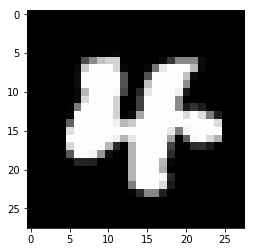

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
5000


In [7]:
# Visualising #
img = (shuffled_x_train[50])
img = img.reshape([28,28])
plt.imshow(img, cmap = 'gray')
plt.show()
print (shuffled_y_train[50])
print (shuffled_x_train.shape[0])

In [8]:
def scale(x):
    x = (x-0.5)/0.5
    return x

In [9]:
def generator(z, ygen, dropout_rate = 0., is_training = True, reuse = False):
    with tf.variable_scope('Generator', reuse = reuse):
        print('\n Generator architecture: ')
        # Layer1
        concat = tf.concat([z,ygen], axis = 3)
        print (concat.shape)
        #?*1*1*110
        
        # Layer 2
        deconv1 = tf.layers.conv2d_transpose(concat, 512, kernel_size = [3,3],
                                         strides = [1,1], padding = 'valid', name = 'deconv1')
        dropout1 = tf.nn.dropout(deconv1, dropout_rate)
        batch1 = tf.layers.batch_normalization(dropout1, training = is_training)
        act1 = tf.nn.leaky_relu(batch1)
        print (act1.shape)
        # ?*3*3*512
        
        # Layer 3
        deconv2 = tf.layers.conv2d_transpose(act1, 256, kernel_size = [5,5],
                                         strides = [1,1], padding = 'valid', name = 'deconv2')
        dropout2 = tf.nn.dropout(deconv2, dropout_rate)
        batch2 = tf.layers.batch_normalization(dropout2, training = is_training)
        act2 = tf.nn.leaky_relu(batch2)
        print (act2.shape)
        #?*7*7*256
        
        # Layer 4
        deconv3 = tf.layers.conv2d_transpose(act2, 128, kernel_size = [4,4],
                                         strides = [2,2], padding = 'same', name = 'deconv3')
        dropout3 = tf.nn.dropout(deconv3, dropout_rate)
        batch3 = tf.layers.batch_normalization(dropout3, training = is_training)
        act3 = tf.nn.leaky_relu(batch3)
        print (act3.shape)
        #?*14*14*128
        
        # Layer 5
        deconv4 = tf.layers.conv2d_transpose(act3, 1, kernel_size = [4,4],
                                         strides = [2,2], padding = 'same', name = 'deconv4')
        act4 = tf.nn.tanh(deconv4)
        print (act4.shape)
        #?*28*28*1
        return act4

In [10]:
# def discriminator(x, ydisc, dropout_rate = 0., is_training = True, reuse = False):
#     with tf.variable_scope('Discriminator', reuse = reuse):
#         print ("\n Discriminator Architecture: ")
#         # Layer1
#         concat = tf.concat([x,ydisc], axis = 3)
#         print (concat.shape)
#         #?*28*28*11
        
#         # Layer2
#         conv1 = tf.layers.conv2d(concat, 128, kernel_size = [4,4],
#                                          strides = [2,2], padding = 'same', name = 'conv1')
#         dropout1 = tf.nn.dropout(conv1, dropout_rate)
#         act1 = tf.nn.leaky_relu(dropout1)
#         print (act1.shape)
#         # ?*14*14*128
        
#         # Layer3
#         conv2 = tf.layers.conv2d(act1, 256, kernel_size = [4,4],
#                                          strides = [2,2], padding = 'same', name = 'conv2')
#         dropout2 = tf.nn.dropout(conv2, dropout_rate)
#         batch2 = tf.layers.batch_normalization(dropout2, training = is_training)
#         act2 = tf.nn.leaky_relu(batch2)
#         print (act2.shape)
#         # ?*7*7*256
        
#         """# Layer4
#         conv3 = tf.layers.conv2d(act2, 512, kernel_size = [5,5],
#                                          strides = [1,1], padding = 'valid', name = 'conv3')
#         dropout3 = tf.nn.dropout(conv3, dropout_rate)
#         batch3 = tf.layers.batch_normalization(dropout3, training = is_training)
#         act3 = tf.nn.leaky_relu(batch3)
#         print (act3.shape)
#         # ?*3*3*512
#         """
        
#         # Layer5
#         D_logits = tf.layers.conv2d(act2, 1, kernel_size = [7,7],
#                                          strides = [1,1], padding = 'valid', name = 'conv4')
#         out = tf.nn.sigmoid(D_logits)
#         print (D_logits.shape)
#         # ?*1*1*1
#         return D_logits, out
        

In [11]:
def discriminator(x, ydisc, dropout_rate = 0., is_training = True, reuse = False):
    with tf.variable_scope('Discriminator', reuse = reuse):
        print ("\n Discriminator Architecture: ")
        # Layer1
        concat = tf.concat([x,ydisc], axis = 3)
        print (concat.shape)
        #?*28*28*11
        
        # Layer2
        conv1 = tf.layers.conv2d(concat, 128, kernel_size = [4,4],
                                         strides = [2,2], padding = 'same', name = 'conv1')
        dropout1 = tf.nn.dropout(conv1, dropout_rate)
        act1 = tf.nn.leaky_relu(dropout1)
        print (act1.shape)
        # ?*14*14*128
        
        # Layer3
        conv2 = tf.layers.conv2d(act1, 256, kernel_size = [4,4],
                                         strides = [2,2], padding = 'same', name = 'conv2')
        dropout2 = tf.nn.dropout(conv2, dropout_rate)
        batch2 = tf.layers.batch_normalization(dropout2, training = is_training)
        act2 = tf.nn.leaky_relu(batch2)
        print (act2.shape)
        # ?*7*7*256
        
        # Layer4
        conv3 = tf.layers.conv2d(act2, 512, kernel_size = [5,5],
                                         strides = [1,1], padding = 'valid', name = 'conv3')
        dropout3 = tf.nn.dropout(conv3, dropout_rate)
        batch3 = tf.layers.batch_normalization(dropout3, training = is_training)
        act3 = tf.nn.leaky_relu(batch3)
        print (act3.shape)
        # ?*3*3*512
        
        # Layer5
        D_logits = tf.layers.conv2d(act3, 1, kernel_size = [3,3],
                                         strides = [1,1], padding = 'valid', name = 'conv4')
        out = tf.nn.sigmoid(D_logits)
        print (D_logits.shape)
        # ?*1*1*1
        return D_logits, out
        

In [12]:
def build_GAN(x, z, ygen, ydisc, dropout_rate, is_training):
    fake_images = generator(z, ygen, dropout_rate, is_training)
    D_real_logits, D_real_prob = discriminator(x, ydisc, dropout_rate, is_training)
    D_fake_logits, D_fake_prob = discriminator(fake_images, ydisc, dropout_rate, is_training, reuse = True)
    return D_real_logits, D_real_prob, D_fake_logits, D_fake_prob, fake_images
    

In [19]:
def loss_fnc(D_real_logits, D_fake_logits):
    D_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits = D_real_logits, labels = tf.ones_like(D_real_logits, dtype = tf.float32)))
    D_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits = D_fake_logits, labels = tf.zeros_like(D_fake_logits, dtype = tf.float32)))
    
    D_loss = D_real_loss + D_fake_loss
    
    G_loss_1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits = D_fake_logits, labels = tf.ones_like(D_fake_logits, dtype = tf.float32)))
    #Feature matching loss
    real_moments = tf.reduce_mean(D_real_logits, axis = 0)
    fake_moments = tf.reduce_mean(D_fake_logits, axis = 0)
    G_loss_2 = tf.reduce_mean(tf.square(real_moments - fake_moments))
    
    #G_loss = G_loss_1 + G_loss_2
    G_loss = G_loss_2
    return D_loss, G_loss
    

In [14]:
def optimizer(D_loss, G_loss, lr, global_step, beta1 = 0.5):
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        all_vars = tf.trainable_variables()
        D_vars = [var for var in all_vars if var.name.startswith('Discriminator')]
        G_vars = [var for var in all_vars if var.name.startswith('Generator')]
        d_train_opt = tf.train.AdamOptimizer(lr, beta1,
                                             name = 'd_optimiser').minimize(D_loss, global_step = global_step, var_list = D_vars)
        # Passing global_step to minimize increments it by 1 everytime d_train_opt is called
        g_train_opt = tf.train.AdamOptimizer(lr, beta1,
                                             name = 'g_optimiser').minimize(G_loss, var_list = G_vars)
    
    return d_train_opt, g_train_opt

In [15]:
def fixed_test_input():
    onehot = np.eye(10)
    fixed_z = np.random.normal(0, 1, (25, 1, 1, 100))  
    y_ = np.random.randint(0, 9, (25, 1))
    fixed_ygen = onehot[y_.astype(np.int32)].reshape([25, 1, 1, 10])
    return fixed_z, fixed_ygen, y_

In [16]:
############ Plotting Results ############
  
def show_result(test_images, num_epoch, show = True, save = False):

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i in range(0, size_figure_grid):
        for j in range(0, size_figure_grid): 
            ax[i, j].get_xaxis().set_visible(False)
            ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (height,width)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        fpath = path + 'Epoch:' + str(num_epoch) +'.png'
        plt.savefig(fpath)
        print ("Figure saved for epoch: " + str(num_epoch))

    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show = False, save = False):
    
    
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        fpath = path + 'Train_hist.png'
        plt.savefig(fpath)
        print("Histogram saved")

    if show:
        plt.show()
    else:
        plt.close()

In [20]:
def train_GAN(batch_size, epochs):
    
    train_hist = {}
    train_hist['D_losses'] = []
    train_hist['G_losses'] = []
    train_hist['Epoch_time'] = []
    
    tf.reset_default_graph()
    
    x = tf.placeholder(tf.float32, shape = [None, height, width, channels], name = 'x')
    z = tf.placeholder(tf.float32, shape = [None, 1, 1, latent], name = 'z')
    ygen = tf.placeholder(tf.float32, shape = [None, 1, 1, num_classes], name = 'ygen')
    ydisc = tf.placeholder(tf.float32, shape = [None, height, width, num_classes], name = 'ydisc')
    dropout_rate = tf.placeholder(tf.float32, name = 'dropout_rate')
    is_training = tf.placeholder(tf.bool, name = 'is_training')
    # Optimizer: set up a variable that's incremented once per batch and
    # controls the learning rate decay.
    global_step = tf.Variable(0, trainable=False)
    # Decay once per epoch, using an exponential schedule starting at 0.0002
    lr = tf.train.exponential_decay(0.0002, global_step, 400, 0.95, staircase=True)
    
    model = build_GAN(x, z, ygen, ydisc, dropout_rate, is_training)
    D_real_logits, D_real_prob, D_fake_logits, D_fake_prob, fake_images = model
    D_loss, G_loss = loss_fnc(D_real_logits, D_fake_logits)
    D_opt, G_opt = optimizer(D_loss, G_loss, lr, global_step)
    fixed_z, fixed_ygen, y_ = fixed_test_input()
    
    print ("\n Conditional input : ")
    print ("\n" + str(y_.reshape([5,5])))
    
    print ("... Training begins ...")
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        no_of_batches = int((shuffled_x_train.shape[0]/batch_size))
        
        for epoch in range(epochs):
            
            epoch_start_time = time.time()
            train_D_losses = []
            train_G_losses = []
            
            for it in range(no_of_batches):
                
                # Discriminator update
                batch_x = shuffled_x_train[it*batch_size : (it+1)*batch_size]
                batch_y = shuffled_y_train[it*batch_size : (it+1)*batch_size]
                # batch[0] has shape: batch_size*28*28*1
                # and batch[1] has shape : batch_size*10
                _x = batch_x
                _ygen = batch_y.reshape([batch_size, 1, 1, num_classes]) # 128*1*1*10 (One hot encoded 4-D)
                _ydisc = _ygen * np.ones([batch_size, height, width, num_classes]) # creates a 128* (3-D matrix with
                # 1's at same level due to one hot encoded multiplication) = 4-D matrix.
                _z = np.random.normal(0, 1, (batch_size, 1, 1, 100))
                
                train_feed_dict = {x:scale(_x), z:_z, ygen:_ygen, ydisc:_ydisc, dropout_rate:0.6,
                                     is_training:True}
                
                D_opt.run(feed_dict = train_feed_dict)
                G_opt.run(feed_dict = train_feed_dict)
                
                train_D_loss = D_loss.eval(feed_dict = train_feed_dict)
                train_G_loss = G_loss.eval(feed_dict = train_feed_dict)
                
                train_D_losses.append(train_D_loss)
                train_G_losses.append(train_G_loss)
                
            epoch_end_time = time.time()
            epoch_time = epoch_end_time - epoch_start_time
            print ('After epoch: '+ str(epoch+1) + ' Generator loss: ' + str(np.mean(train_G_losses)) +
                   ' Discriminator loss: ' + str(np.mean(train_D_losses)) + ' Time taken for epoch: ' + str(epoch_time) +'\n')
            
            train_hist['D_losses'].append(np.mean(train_D_losses))
            train_hist['G_losses'].append(np.mean(train_G_losses))
            train_hist['Epoch_time'].append(epoch_time)
            
            test_images = fake_images.eval(feed_dict = {z:fixed_z, ygen:fixed_ygen, dropout_rate:0.6, is_training:False})
            show_result(test_images, num_epoch = epoch+1, show = True, save = True)
            
        print ("\n... Training finish ...\n")
        print (" Total time taken : " + str(np.sum(train_hist['Epoch_time'])))
        show_train_hist(train_hist, show = True, save = True)
        sess.close()


 Generator architecture: 
(?, 1, 1, 110)
(?, 3, 3, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)

 Discriminator Architecture: 
(?, 28, 28, 11)
(?, 14, 14, 128)
(?, 7, 7, 256)
(?, 3, 3, 512)
(?, 1, 1, 1)

 Discriminator Architecture: 
(?, 28, 28, 11)
(?, 14, 14, 128)
(?, 7, 7, 256)
(?, 3, 3, 512)
(?, 1, 1, 1)

 Conditional input : 

[[5 0 1 7 3]
 [6 5 1 0 5]
 [8 2 2 0 2]
 [7 4 0 7 8]
 [1 6 4 3 2]]
... Training begins ...
After epoch: 1 Generator loss: 8.455867 Discriminator loss: 0.7637578 Time taken for epoch: 6.777211427688599

Figure saved for epoch: 1


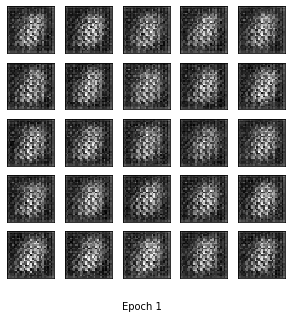

After epoch: 2 Generator loss: 18.565657 Discriminator loss: 0.6321174 Time taken for epoch: 5.696538209915161

Figure saved for epoch: 2


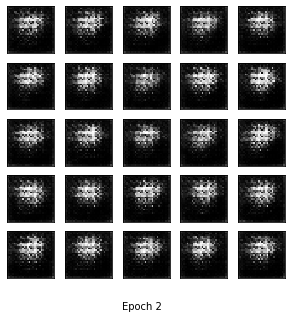

After epoch: 3 Generator loss: 33.322624 Discriminator loss: 0.45953512 Time taken for epoch: 5.692980766296387

Figure saved for epoch: 3


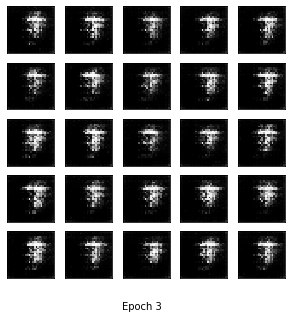

After epoch: 4 Generator loss: 64.739975 Discriminator loss: 0.25837424 Time taken for epoch: 5.668198347091675

Figure saved for epoch: 4


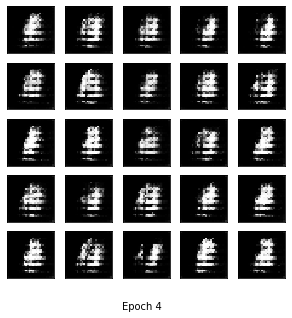

After epoch: 5 Generator loss: 31.4048 Discriminator loss: 0.69201094 Time taken for epoch: 5.668366432189941

Figure saved for epoch: 5


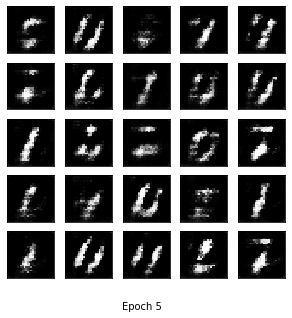

After epoch: 6 Generator loss: 21.383476 Discriminator loss: 0.5740599 Time taken for epoch: 5.699917316436768

Figure saved for epoch: 6


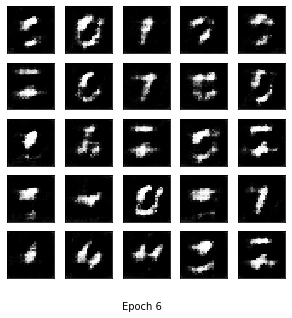

After epoch: 7 Generator loss: 16.741262 Discriminator loss: 0.70434314 Time taken for epoch: 5.690865993499756

Figure saved for epoch: 7


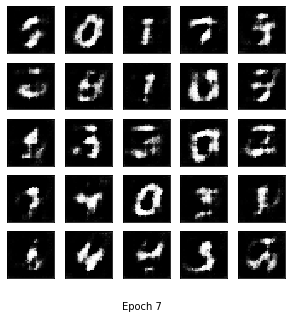

After epoch: 8 Generator loss: 10.317382 Discriminator loss: 0.87889194 Time taken for epoch: 5.679616212844849

Figure saved for epoch: 8


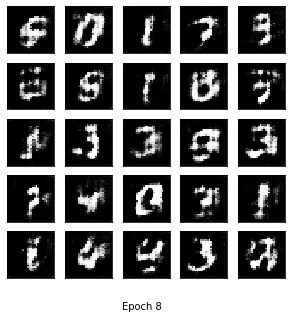

After epoch: 9 Generator loss: 9.018259 Discriminator loss: 0.89424366 Time taken for epoch: 5.679189920425415

Figure saved for epoch: 9


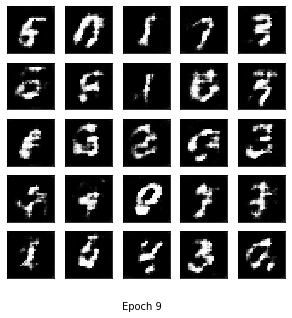

After epoch: 10 Generator loss: 7.027915 Discriminator loss: 0.94862735 Time taken for epoch: 5.674574375152588

Figure saved for epoch: 10


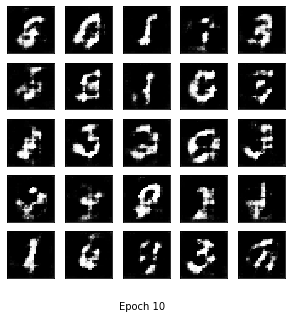

After epoch: 11 Generator loss: 7.7427173 Discriminator loss: 0.837054 Time taken for epoch: 5.664254903793335

Figure saved for epoch: 11


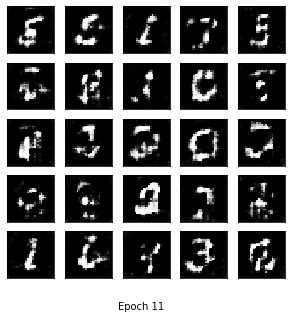

After epoch: 12 Generator loss: 7.562741 Discriminator loss: 0.8720933 Time taken for epoch: 5.697865962982178

Figure saved for epoch: 12


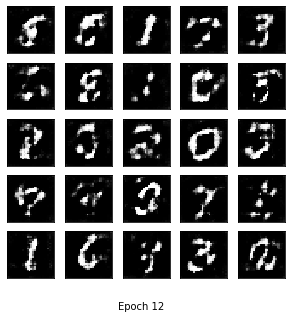

After epoch: 13 Generator loss: 7.6897717 Discriminator loss: 0.82899654 Time taken for epoch: 5.692368984222412

Figure saved for epoch: 13


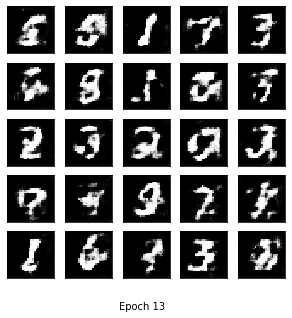

After epoch: 14 Generator loss: 7.6207423 Discriminator loss: 0.83703953 Time taken for epoch: 5.695650577545166

Figure saved for epoch: 14


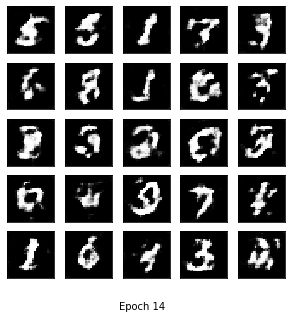

After epoch: 15 Generator loss: 7.07223 Discriminator loss: 0.87829775 Time taken for epoch: 5.689186096191406

Figure saved for epoch: 15


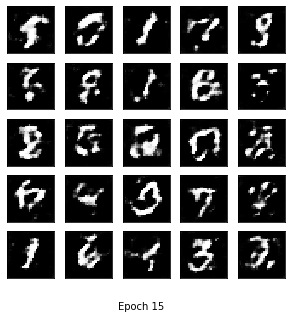

After epoch: 16 Generator loss: 7.199519 Discriminator loss: 0.8117775 Time taken for epoch: 5.686206102371216

Figure saved for epoch: 16


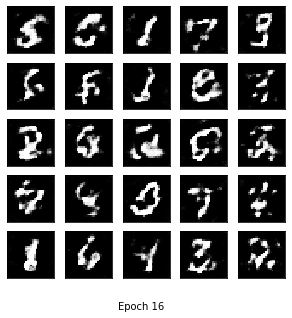

After epoch: 17 Generator loss: 8.136669 Discriminator loss: 0.81313056 Time taken for epoch: 5.695861577987671

Figure saved for epoch: 17


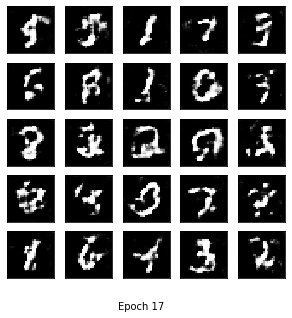

After epoch: 18 Generator loss: 8.750491 Discriminator loss: 0.77172154 Time taken for epoch: 5.680892467498779

Figure saved for epoch: 18


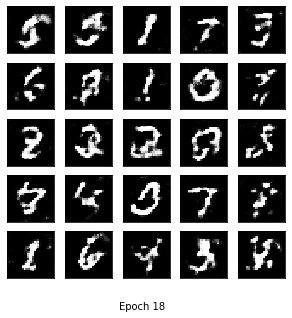

After epoch: 19 Generator loss: 8.195523 Discriminator loss: 0.7974349 Time taken for epoch: 5.70512318611145

Figure saved for epoch: 19


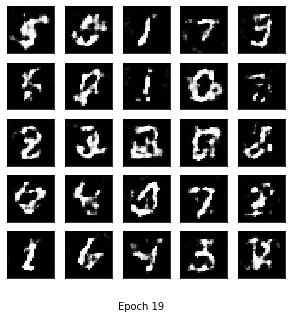

After epoch: 20 Generator loss: 8.636568 Discriminator loss: 0.8011185 Time taken for epoch: 5.689119100570679

Figure saved for epoch: 20


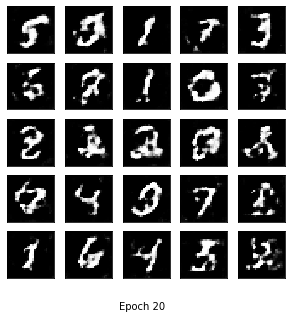

After epoch: 21 Generator loss: 8.777867 Discriminator loss: 0.76411986 Time taken for epoch: 5.688298225402832

Figure saved for epoch: 21


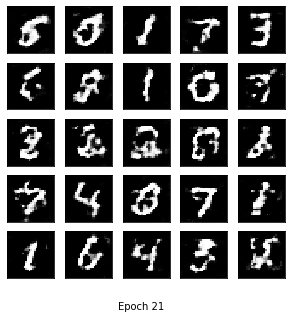

After epoch: 22 Generator loss: 10.340835 Discriminator loss: 0.696085 Time taken for epoch: 5.695191144943237

Figure saved for epoch: 22


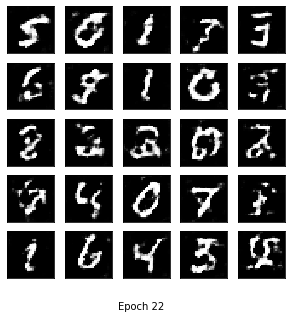

After epoch: 23 Generator loss: 11.080188 Discriminator loss: 0.6736511 Time taken for epoch: 5.682860612869263

Figure saved for epoch: 23


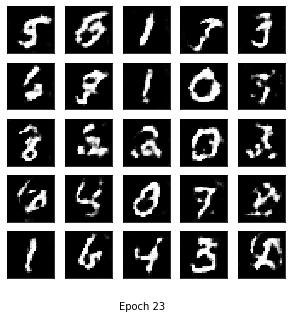

After epoch: 24 Generator loss: 12.117526 Discriminator loss: 0.7071079 Time taken for epoch: 5.6724371910095215

Figure saved for epoch: 24


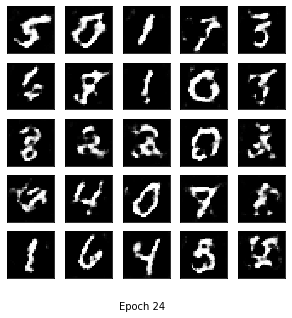

After epoch: 25 Generator loss: 12.051684 Discriminator loss: 0.63894373 Time taken for epoch: 5.694202661514282

Figure saved for epoch: 25


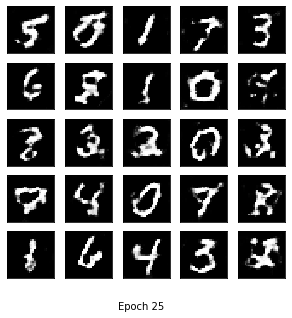

After epoch: 26 Generator loss: 12.457301 Discriminator loss: 0.6837301 Time taken for epoch: 5.691296100616455

Figure saved for epoch: 26


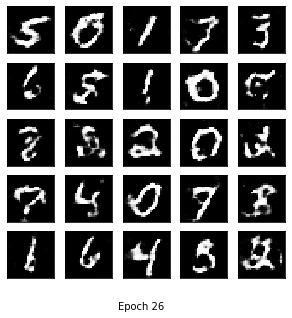

After epoch: 27 Generator loss: 12.338194 Discriminator loss: 0.7028011 Time taken for epoch: 5.695045709609985

Figure saved for epoch: 27


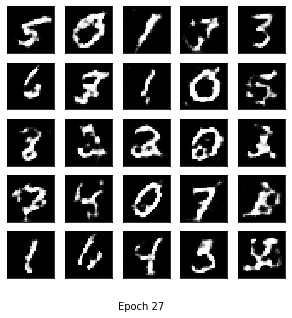

After epoch: 28 Generator loss: 11.451258 Discriminator loss: 0.7232305 Time taken for epoch: 5.690667629241943

Figure saved for epoch: 28


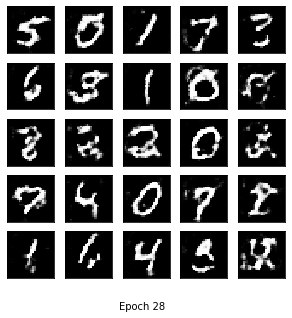

After epoch: 29 Generator loss: 10.424394 Discriminator loss: 0.70471406 Time taken for epoch: 5.699130535125732

Figure saved for epoch: 29


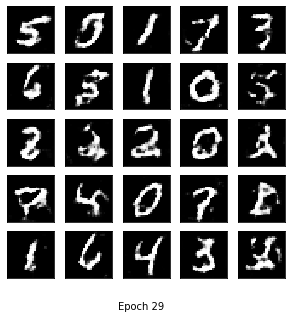

After epoch: 30 Generator loss: 10.198023 Discriminator loss: 0.76572853 Time taken for epoch: 5.696821689605713

Figure saved for epoch: 30


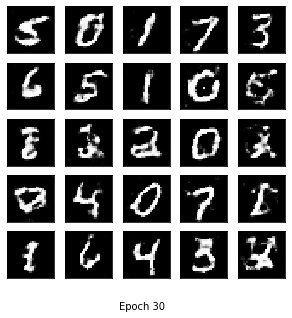

After epoch: 31 Generator loss: 9.864809 Discriminator loss: 0.7644663 Time taken for epoch: 5.7000648975372314

Figure saved for epoch: 31


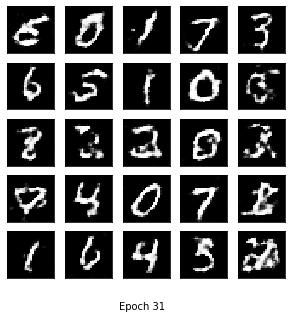

After epoch: 32 Generator loss: 9.904966 Discriminator loss: 0.7500269 Time taken for epoch: 5.727302312850952

Figure saved for epoch: 32


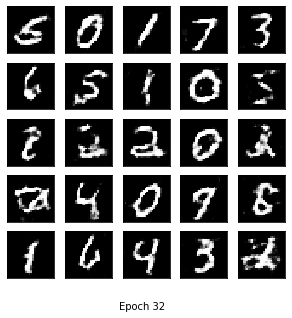

After epoch: 33 Generator loss: 9.237367 Discriminator loss: 0.8063667 Time taken for epoch: 5.681877613067627

Figure saved for epoch: 33


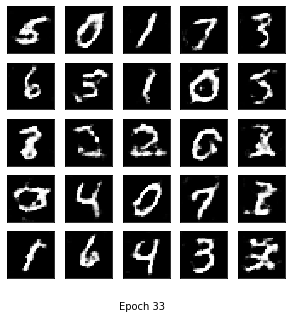

After epoch: 34 Generator loss: 9.109127 Discriminator loss: 0.7874937 Time taken for epoch: 5.693148374557495

Figure saved for epoch: 34


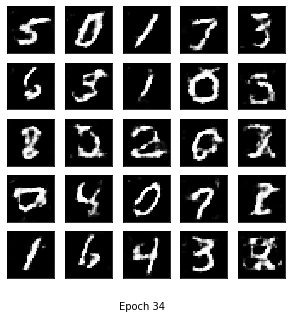

After epoch: 35 Generator loss: 8.816402 Discriminator loss: 0.7602164 Time taken for epoch: 5.7122509479522705

Figure saved for epoch: 35


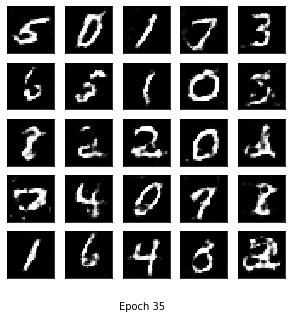

After epoch: 36 Generator loss: 8.537123 Discriminator loss: 0.7737302 Time taken for epoch: 5.703392744064331

Figure saved for epoch: 36


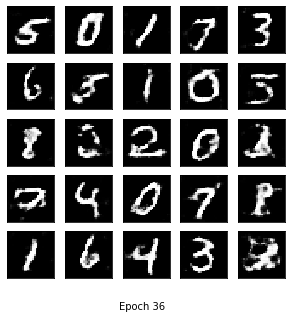

After epoch: 37 Generator loss: 8.596101 Discriminator loss: 0.8063893 Time taken for epoch: 5.706517696380615

Figure saved for epoch: 37


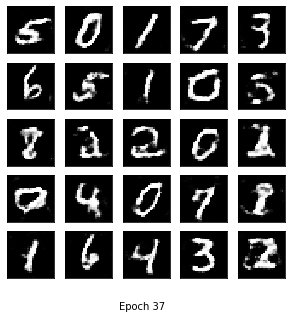

After epoch: 38 Generator loss: 8.400157 Discriminator loss: 0.79279995 Time taken for epoch: 5.700034856796265

Figure saved for epoch: 38


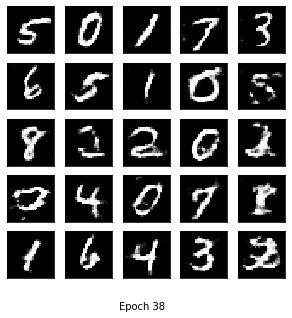

After epoch: 39 Generator loss: 8.47993 Discriminator loss: 0.7973648 Time taken for epoch: 5.70241904258728

Figure saved for epoch: 39


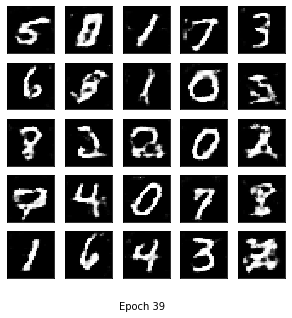

After epoch: 40 Generator loss: 7.9475513 Discriminator loss: 0.8186816 Time taken for epoch: 5.713483810424805

Figure saved for epoch: 40


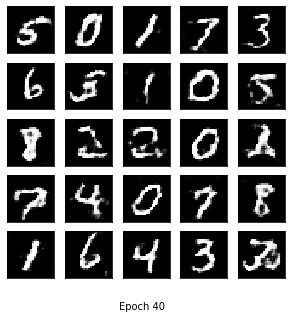

After epoch: 41 Generator loss: 8.017951 Discriminator loss: 0.81318337 Time taken for epoch: 5.7105302810668945

Figure saved for epoch: 41


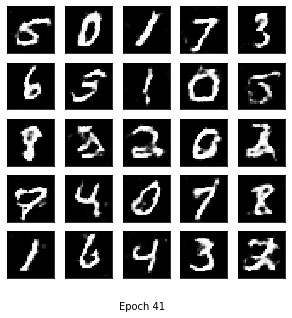

After epoch: 42 Generator loss: 8.41028 Discriminator loss: 0.8029824 Time taken for epoch: 5.704144477844238

Figure saved for epoch: 42


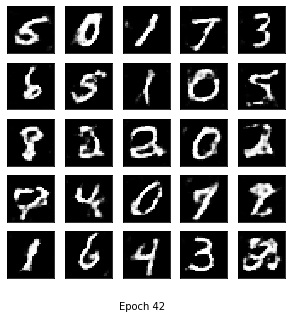

After epoch: 43 Generator loss: 7.8312354 Discriminator loss: 0.8225539 Time taken for epoch: 5.717822313308716

Figure saved for epoch: 43


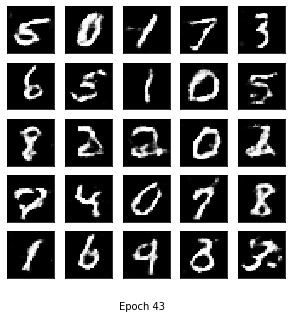

After epoch: 44 Generator loss: 8.120264 Discriminator loss: 0.7905405 Time taken for epoch: 5.6570000648498535

Figure saved for epoch: 44


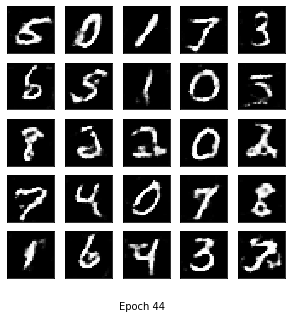

After epoch: 45 Generator loss: 8.626289 Discriminator loss: 0.80764174 Time taken for epoch: 5.702811241149902

Figure saved for epoch: 45


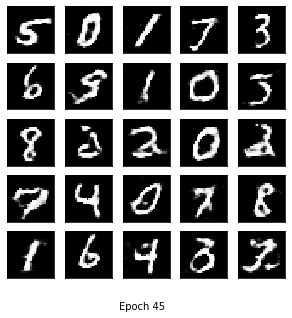

After epoch: 46 Generator loss: 7.423508 Discriminator loss: 0.8097945 Time taken for epoch: 5.720820903778076

Figure saved for epoch: 46


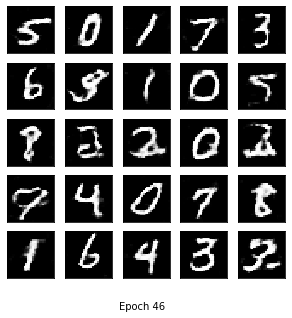

After epoch: 47 Generator loss: 8.391459 Discriminator loss: 0.8114466 Time taken for epoch: 5.720163106918335

Figure saved for epoch: 47


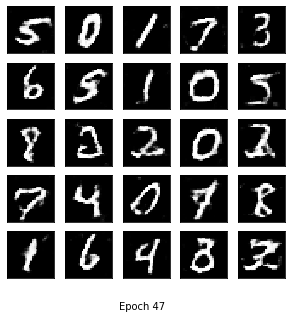

After epoch: 48 Generator loss: 7.986454 Discriminator loss: 0.8592125 Time taken for epoch: 5.69940710067749

Figure saved for epoch: 48


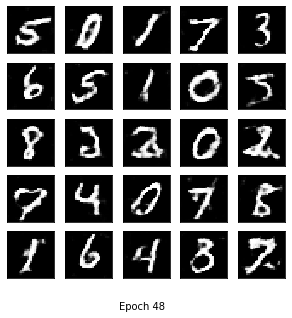

After epoch: 49 Generator loss: 7.718468 Discriminator loss: 0.7725583 Time taken for epoch: 5.7362165451049805

Figure saved for epoch: 49


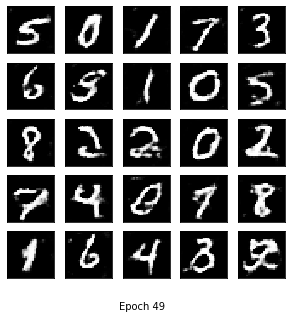

After epoch: 50 Generator loss: 8.008351 Discriminator loss: 0.7883675 Time taken for epoch: 5.694183826446533

Figure saved for epoch: 50


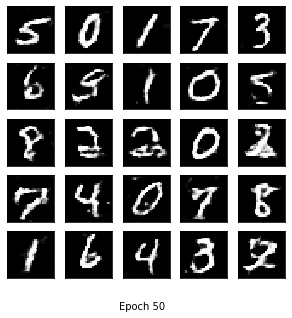

After epoch: 51 Generator loss: 8.098165 Discriminator loss: 0.8048559 Time taken for epoch: 5.714251518249512

Figure saved for epoch: 51


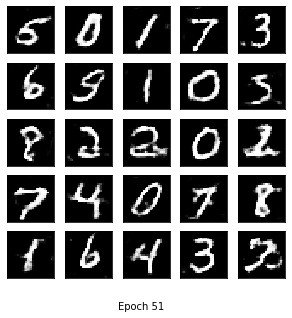

After epoch: 52 Generator loss: 8.128683 Discriminator loss: 0.8017112 Time taken for epoch: 5.671422958374023

Figure saved for epoch: 52


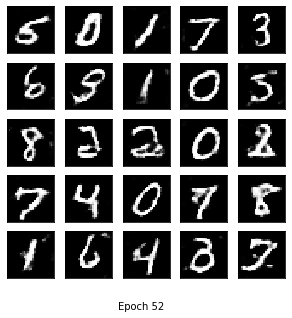

After epoch: 53 Generator loss: 8.019085 Discriminator loss: 0.8047547 Time taken for epoch: 5.70075249671936

Figure saved for epoch: 53


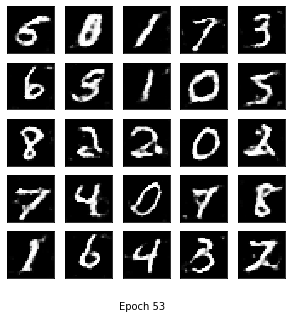

After epoch: 54 Generator loss: 8.1639185 Discriminator loss: 0.7921494 Time taken for epoch: 5.716603994369507

Figure saved for epoch: 54


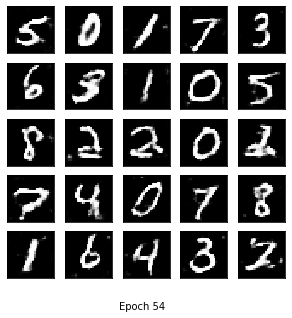

After epoch: 55 Generator loss: 7.6789865 Discriminator loss: 0.7927144 Time taken for epoch: 5.687930107116699

Figure saved for epoch: 55


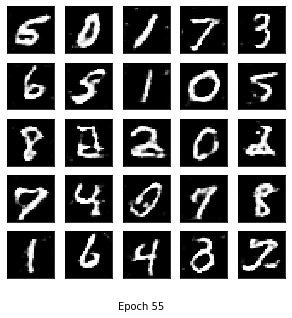

After epoch: 56 Generator loss: 7.8294277 Discriminator loss: 0.785694 Time taken for epoch: 5.70462965965271

Figure saved for epoch: 56


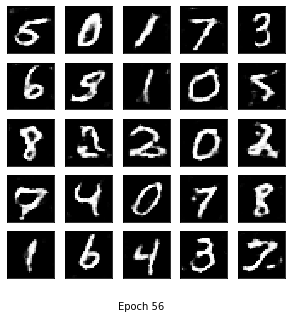

After epoch: 57 Generator loss: 8.502001 Discriminator loss: 0.8010045 Time taken for epoch: 5.696191310882568

Figure saved for epoch: 57


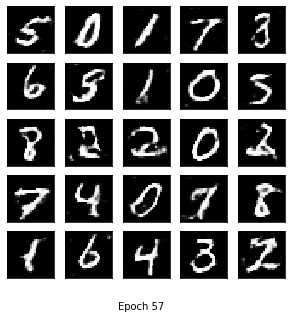

After epoch: 58 Generator loss: 8.102058 Discriminator loss: 0.7943944 Time taken for epoch: 5.716902017593384

Figure saved for epoch: 58


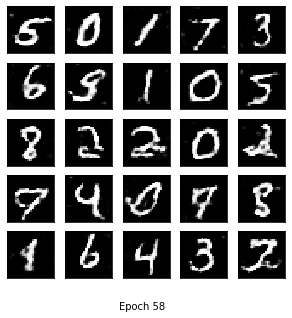

After epoch: 59 Generator loss: 8.60258 Discriminator loss: 0.76693773 Time taken for epoch: 5.712994813919067

Figure saved for epoch: 59


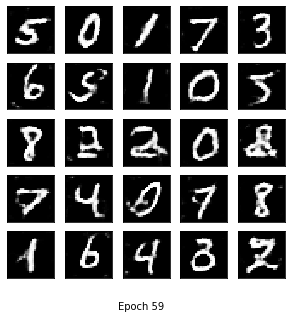

After epoch: 60 Generator loss: 8.593977 Discriminator loss: 0.8030247 Time taken for epoch: 5.705569744110107

Figure saved for epoch: 60


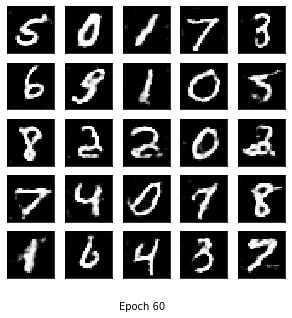

After epoch: 61 Generator loss: 7.691295 Discriminator loss: 0.8172159 Time taken for epoch: 5.665325164794922

Figure saved for epoch: 61


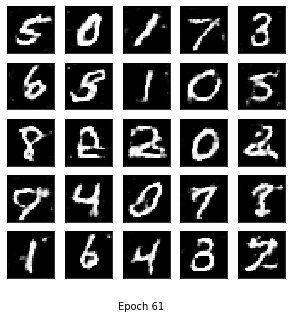

After epoch: 62 Generator loss: 8.5022 Discriminator loss: 0.76906943 Time taken for epoch: 5.685105085372925

Figure saved for epoch: 62


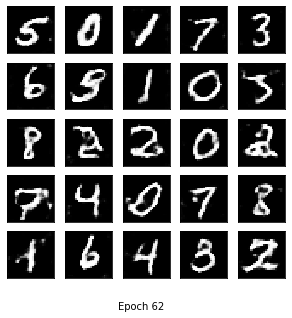

After epoch: 63 Generator loss: 8.1258 Discriminator loss: 0.7587419 Time taken for epoch: 5.7160937786102295

Figure saved for epoch: 63


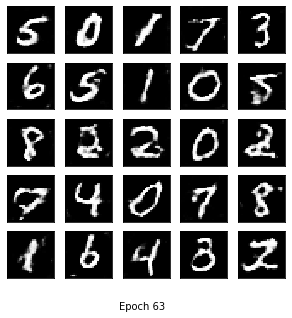

After epoch: 64 Generator loss: 8.425692 Discriminator loss: 0.75465053 Time taken for epoch: 5.706561803817749

Figure saved for epoch: 64


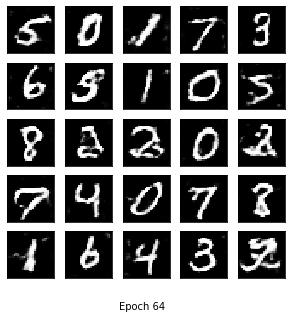

After epoch: 65 Generator loss: 8.425341 Discriminator loss: 0.80700105 Time taken for epoch: 5.697739839553833

Figure saved for epoch: 65


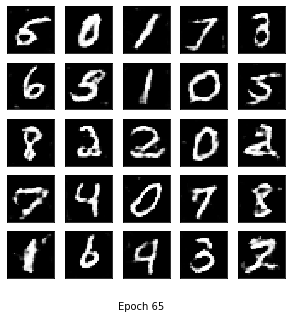

After epoch: 66 Generator loss: 8.149691 Discriminator loss: 0.7766531 Time taken for epoch: 5.695008754730225

Figure saved for epoch: 66


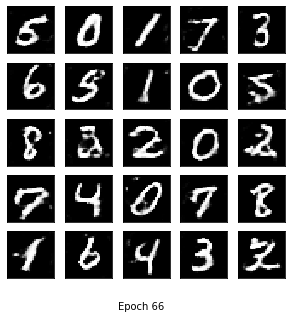

After epoch: 67 Generator loss: 8.931821 Discriminator loss: 0.75819993 Time taken for epoch: 5.690692663192749

Figure saved for epoch: 67


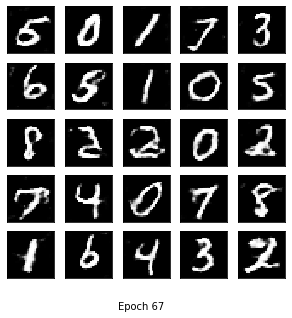

After epoch: 68 Generator loss: 8.659127 Discriminator loss: 0.76309407 Time taken for epoch: 5.719951152801514

Figure saved for epoch: 68


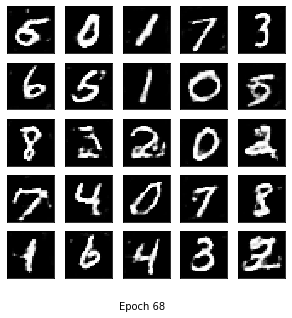

After epoch: 69 Generator loss: 9.009685 Discriminator loss: 0.7549065 Time taken for epoch: 5.69035267829895

Figure saved for epoch: 69


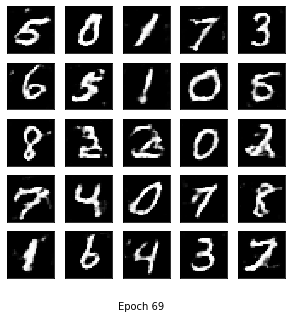

After epoch: 70 Generator loss: 8.818331 Discriminator loss: 0.7869806 Time taken for epoch: 5.715947389602661

Figure saved for epoch: 70


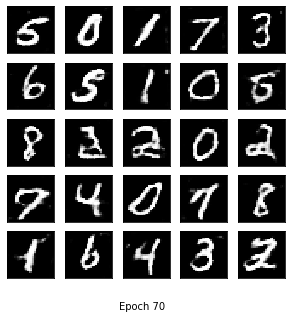

After epoch: 71 Generator loss: 8.920307 Discriminator loss: 0.7765954 Time taken for epoch: 5.700640678405762

Figure saved for epoch: 71


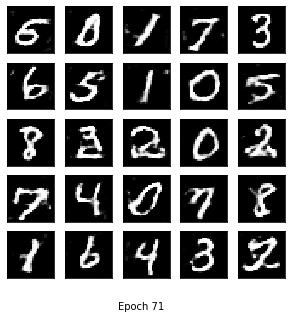

After epoch: 72 Generator loss: 9.037336 Discriminator loss: 0.7639099 Time taken for epoch: 5.718169689178467

Figure saved for epoch: 72


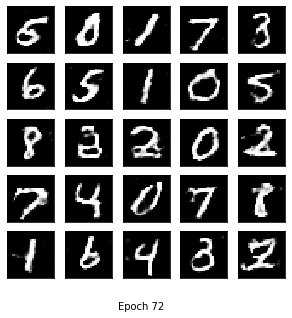

After epoch: 73 Generator loss: 8.840103 Discriminator loss: 0.7306386 Time taken for epoch: 5.682983160018921

Figure saved for epoch: 73


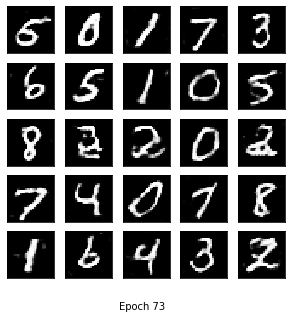

After epoch: 74 Generator loss: 9.995405 Discriminator loss: 0.7442125 Time taken for epoch: 5.7176103591918945

Figure saved for epoch: 74


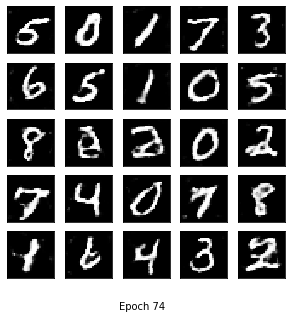

After epoch: 75 Generator loss: 9.798656 Discriminator loss: 0.7273195 Time taken for epoch: 5.698269844055176

Figure saved for epoch: 75


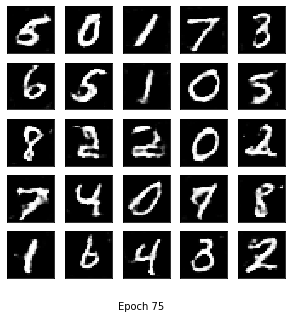

After epoch: 76 Generator loss: 9.012746 Discriminator loss: 0.76510644 Time taken for epoch: 5.701426029205322

Figure saved for epoch: 76


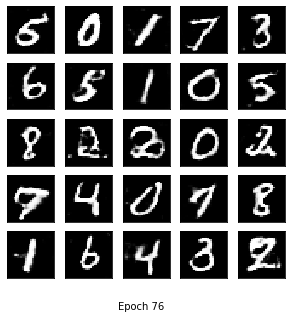

After epoch: 77 Generator loss: 10.6245365 Discriminator loss: 0.7395548 Time taken for epoch: 5.6932432651519775

Figure saved for epoch: 77


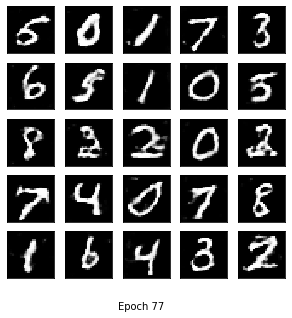

After epoch: 78 Generator loss: 10.655922 Discriminator loss: 0.69281846 Time taken for epoch: 5.69476056098938

Figure saved for epoch: 78


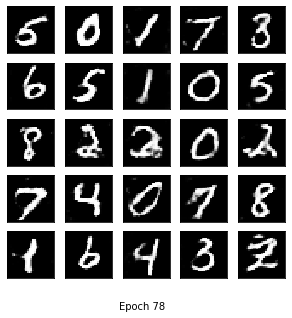

After epoch: 79 Generator loss: 10.52285 Discriminator loss: 0.7628823 Time taken for epoch: 5.715696096420288

Figure saved for epoch: 79


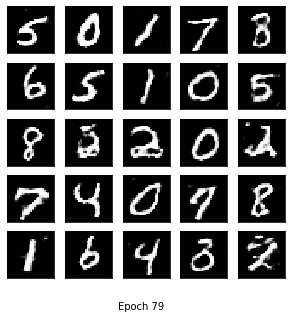

After epoch: 80 Generator loss: 9.582438 Discriminator loss: 0.7294536 Time taken for epoch: 5.713970184326172

Figure saved for epoch: 80


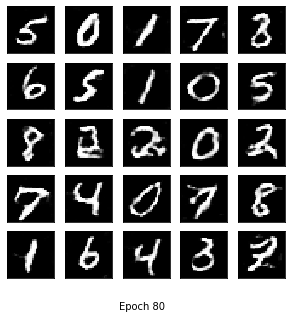

After epoch: 81 Generator loss: 10.217623 Discriminator loss: 0.72173166 Time taken for epoch: 5.697486162185669

Figure saved for epoch: 81


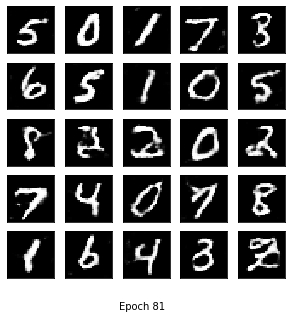

After epoch: 82 Generator loss: 10.157887 Discriminator loss: 0.7382875 Time taken for epoch: 5.720275402069092

Figure saved for epoch: 82


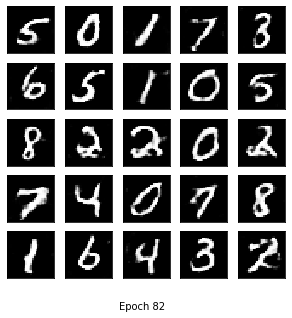

After epoch: 83 Generator loss: 10.846675 Discriminator loss: 0.70128036 Time taken for epoch: 5.706977844238281

Figure saved for epoch: 83


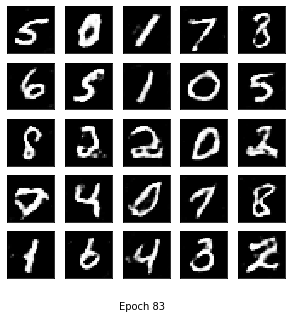

After epoch: 84 Generator loss: 11.342909 Discriminator loss: 0.7065405 Time taken for epoch: 5.6977245807647705

Figure saved for epoch: 84


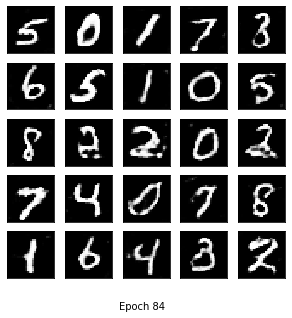

After epoch: 85 Generator loss: 11.279624 Discriminator loss: 0.6713805 Time taken for epoch: 5.701760768890381

Figure saved for epoch: 85


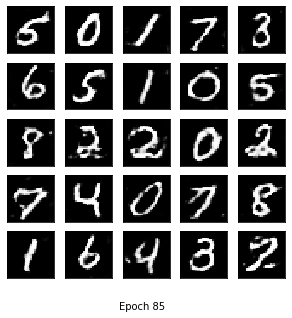


... Training finish ...

 Total time taken : 485.40455317497253
Histogram saved


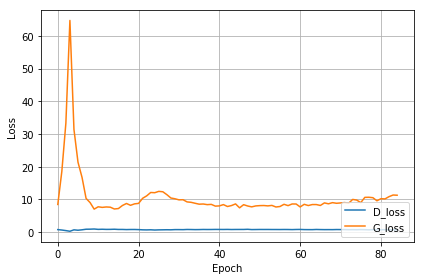

In [21]:
solver = train_GAN(128,85)